In [ ]:
#@title 
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
%cd /content/drive/MyDrive/computer-vision-um/cv-um-2021/trabajo-final/


# Ejercicio 2.2: Face Recognition

Tal como se explica en la letra del obligatorio final en este ejercicio es necesario implementar una solucion para reconocimiento de facial. Se proveen datos de entrenamiento y es necesario entrenar un clasificador para hacer el reconocimiento. Todo el código necesario para comenzar a trabajar está provisto en este notebook.


\**En los ejercicios del trabajo final es posible utilizar funciones de librerias existentes o código sacado de internet. Siempre y cuando **no se usen para resolver explicitamente lo que pide el ejercicio** y al código sacado de interenet le agreguen el link en comentarios de donde fue sacado ese código.*



In [203]:
import cv2 
import numpy as np
import os
import sklearn 
import sklearn.neighbors
import matplotlib.pyplot as plt
import pickle
import sys
import scipy.io
from skimage.feature import hog
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, train_test_split



### Cargar Datos de Entrenamiento y Validación


In [94]:
data_dir='./data'
face_recognition_dir = os.path.join(data_dir, 'face_recognition')
training_data_file = os.path.join(face_recognition_dir, 'face_recognition_data_tr.mat')
validation_data_file = os.path.join(face_recognition_dir, 'face_recognition_data_va.mat')

In [95]:
training_data_mat = scipy.io.loadmat(training_data_file)
validation_data_mat = scipy.io.loadmat(validation_data_file)

In [96]:
training_data=training_data_mat['tr_img_sample']
validation_data = validation_data_mat['va_img_sample']

### Esqueleto de funciones para extracción de Features

In [97]:
# import the necessary packages
from skimage import feature
import numpy as np
class LocalBinaryPatterns:
	def __init__(self, numPoints, radius):
		self.numPoints = numPoints
		self.radius = radius
	def describe(self, image, eps=1e-7):
		lbp = feature.local_binary_pattern(image, self.numPoints,
			self.radius, method="uniform")
		(hist, _) = np.histogram(lbp.ravel(),
			bins=np.arange(0, self.numPoints + 3),
			range=(0, self.numPoints + 2))
		hist = hist.astype("float")
		hist /= (hist.sum() + eps)
		return hist

In [183]:
# initialize the local binary patterns descriptor along with
# the data and label lists
desc = LocalBinaryPatterns(30, 10)
data = []
labels = []

### Armar los datos de entrenamiento y sus etiquetas

In [184]:
training_images = []
training_labels = []
for training_image in training_data:
    image = (training_image[0]/255)
    label = training_image[2]
    training_images.append(image.reshape(64*64))
    training_labels.append(label.reshape(1))

training_images = np.asarray(training_images)
training_labels = np.asarray(training_labels)
training_labels = training_labels.reshape(training_labels.shape[0])

In [186]:
training_labels.shape

(368,)

### Construir datos de validación y sus etiquetas


In [187]:
validation_images = []
validation_labels = []
validation_names = []
for validation_image in validation_data:
    image = (validation_image[0]/255)
    label = validation_image[2] 
    name = validation_image[1][0].split('.')[0]
    validation_images.append(image.reshape(64*64))
    validation_labels.append(label.reshape(1))
    validation_names.append(name)

validation_images = np.asarray(validation_images)
validation_labels = np.asarray(validation_labels)
validation_labels = validation_labels.reshape(validation_labels.shape[0])

In [223]:
def extract_hog_features(img, resize_size=(64,64)):
    resized_image = cv2.resize(img,resize_size)
    image_representation = resized_image.reshape(resize_size[0]*resize_size[1])
    fd, hog_image = hog(resized_image, orientations=9, pixels_per_cell=(8, 8),
                	cells_per_block=(2, 2), visualize=True, multichannel=True)
    return hog_image

In [228]:
val_data = [desc.describe(image[0]) for image in validation_data]
# val_data_hog = [extract_hog_features(image[0]) for image in validation_data]

In [215]:
grid = GridSearchCV(sklearn.svm.SVC(), {'C': [1, 5, 10, 30, 50, 100, 200], 'kernel': ['linear', 'rbf', 'sigmoid'], 'probability':[True]})
grid.fit(data, training_labels)
print(grid.best_score_, grid.best_params_)

model = grid.best_estimator_



0.1467974824139208 {'C': 200, 'kernel': 'rbf', 'probability': True}


In [190]:
# knn_classifier = sklearn.neighbors.KNeighborsClassifier(n_neighbors=3,algorithm='brute')
# knn_classifier.fit(training_images,training_labels)

#### Guardar Modelo Entrenado

In [216]:
pickle.dump(model,open('./face_recogition', 'wb'))

#### Cargar modelo

In [217]:
classifier = pickle.load(open('./face_recogition','rb'))

### Clasificar los datos de validación


In [193]:
# labels = classifier.predict(validation_images)
# ## Get score for each sliding window patch
# scores = classifier.predict_proba(validation_images)

In [218]:
labels = classifier.predict(val_data)
## Get score for each sliding window patch
scores = classifier.predict_proba(val_data)

###  Evaluar modelo de Reconocimento

In [219]:
acc = np.mean(labels==validation_labels)*100

In [220]:
print('The accuracy of face recognition is:%.2f \n' % acc)


The accuracy of face recognition is:21.62 



### Visualize Recognition ###

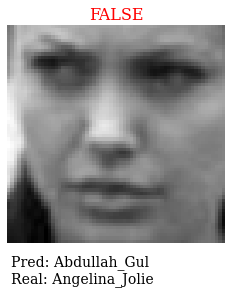

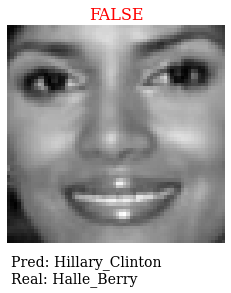

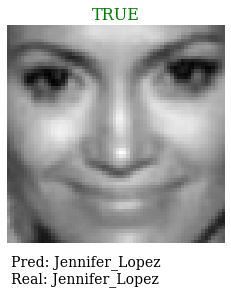

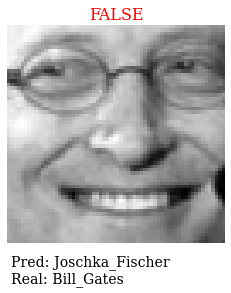

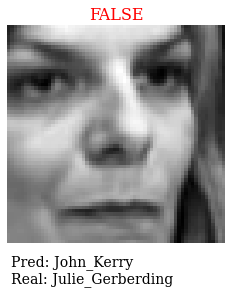

In [197]:
indexes = [13,50,77,18,110] # You can use Random Sample
for index in indexes:
    predicted_label=labels[index]
    real_label = validation_labels[index]

    pred_name = validation_names[np.nonzero(validation_labels==predicted_label)[0][0]]
    real_name = validation_names[np.nonzero(validation_labels==real_label)[0][0]]
    if real_label==predicted_label:
        text='TRUE'
        color='g'
    else:
        text='FALSE'
        color='r'
    font = {'family': 'serif',
            'color':  color,
            'weight': 'normal',
            'size': 16,
            }    
    plt.imshow(validation_images[index].reshape(64,64), cmap='gray')
    plt.axis('off')
    plt.title(text, fontdict=font)
    sub_font = {'family': 'serif',
            'weight': 'normal',
            'size': 14,
            }    
    plt.text(0.5, 75, 'Pred: {} \nReal: {}'.format(pred_name[:-5],real_name[:-5]), fontdict=sub_font)

    plt.show()
